In [1]:
import os
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from google.colab import drive, files

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/char_gender/data/'

In [4]:
df = pd.read_csv(os.path.join(data_dir, 'char_gender_final.csv'), header=1).iloc[1:].rename(columns={'Recorded Date': 'date',
                           'First Story': 'First_Story'.lower(),
                           'First Gender': 'First_Gender'.lower(),
                           'Your gender - Selected Choice':'gender',
                           'Suppose you had both novels in your hand. Which one would you continue reading?': 'chosen_story'})
print(len(df))
# df[:1]

3508


In [5]:
rids_awesome = []

for index, row in df.iterrows():

  cond_hike = (row['In Novel A, how long is the trail that Sam takes?'] == '6 miles') and (row['In Novel A, what plant does Sam rest against?'] == 'Juniper tree') and (row['In Novel B, when does Alex go to the cafe?'] == 'Morning') and (row['In Novel B, what is the material of the chair Alex sketches?'] == 'Wood')

  cond_coffee = (row['In Novel B, how long is the trail that Sam takes?'] == '6 miles') and (row['In Novel B, what plant does Sam rest against?'] == 'Juniper tree') and (row['In Novel A, when does Alex go to the cafe?'] == 'Morning') and (row['In Novel A, what is the material of the chair Alex sketches?'] == 'Wood')

  recent = '2024-05' in row['date'] and int(row['date'].split('-')[2][:2]) > 16
  complete = not pd.isna(row['chosen_story']) and not pd.isna(row['gender'])
  correct = cond_hike or cond_coffee

  if recent and complete and correct:

    rids_awesome.append(row['Response ID'])

print(len(rids_awesome))

3002


In [6]:
awesome = df.set_index('Response ID').loc[rids_awesome[:3000]]

In [7]:
enby = 0
rids_clean = []
for index, row in awesome.iterrows():
  if row['gender'] == 'Woman' or row['gender'] == 'Man':
    rids_clean.append(index)
  else:
    enby += 1
enby

17

In [8]:
clean = df.set_index('Response ID').loc[rids_clean]
len(clean)

2983

In [9]:
chose_woman = []
treatmentA = []
chose_hike = []

for index, row in clean.iterrows():

  if (row['first_gender'] == 'W' and row['chosen_story'] == 'Novel A') or (row['first_gender'] == 'M' and row['chosen_story'] == 'Novel B'):
    chose_woman.append(1)
  else:
    chose_woman.append(0)

  if (row['first_gender'] == 'W' and row['first_story'] == 'Hike') or (row['first_gender'] == 'M' and row['first_story'] == 'Coffee'):
    treatmentA.append('Hike')
  else:
    treatmentA.append('Other')

  if (row['first_story'] == 'Hike' and row['chosen_story'] == 'Novel A') or (row['first_story'] == 'Coffee' and row['chosen_story'] == 'Novel B'):
    chose_hike.append(1)
  else:
    chose_hike.append(0)

clean['chose_woman'] = chose_woman
clean['Treatment A'] = treatmentA
clean['chose_hike'] = chose_hike

In [10]:
2983-1465

1518

In [11]:
clean['respondent_woman'] = clean['gender'].apply(lambda x: 1 if x == 'Woman' else 0)

In [12]:
W = 0
M = 0
for x in clean['gender']:
  if x == 'Woman':
    W += 1
  else:
    M += 1
print(W, M)

1492 1491


In [ ]:
#clean.to_csv(os.path.join(data_dir, 'clean_recent.csv'))

In [14]:
clean.columns[16:]

Index(['If you agree to these conditions, please click "I consent to participate" below. If you do not agree, click the “I do not consent to participate” option.\n\nBy agreeing to participate, you confirm that you are over 18 years of age.\n\n \n\nI have read the above information.',
       'What is your Prolific ID?\n\nPlease note that this response should auto-fill with the correct ID.',
       'In Novel A, how long is the trail that Sam takes?',
       'In Novel A, what plant does Sam rest against?',
       'In Novel B, when does Alex go to the cafe?',
       'In Novel B, what is the material of the chair Alex sketches?',
       'chosen_story',
       'Your opinion is fundamental to understand reader preferences. Please take your time to answer this question.\n\nIn your own words, briefly share your motivation for your choice (minimum 200 characters, or about 40 words).',
       'Your age:', 'gender', 'Your gender - Prefer to self describe: - Text',
       'What was your total famil

In [18]:
public = clean[clean.columns[16:]].drop(columns=['PROLIFIC_PID'])
public.to_csv(os.path.join(data_dir, 'public_data.csv'))
public.head()

,"If you agree to these conditions, please click ""I consent to participate"" below. If you do not agree, click the “I do not consent to participate” option.\n\nBy agreeing to participate, you confirm that you are over 18 years of age.\n\n \n\nI have read the above information.",What is your Prolific ID?\n\nPlease note that this response should auto-fill with the correct ID.,"In Novel A, how long is the trail that Sam takes?","In Novel A, what plant does Sam rest against?","In Novel B, when does Alex go to the cafe?","In Novel B, what is the material of the chair Alex sketches?",chosen_story,"Your opinion is fundamental to understand reader preferences. Please take your time to answer this question.\n\nIn your own words, briefly share your motivation for your choice (minimum 200 characters, or about 40 words).",Your age:,gender,...,"In Novel A, what is the material of the chair Alex sketches?","In Novel B, how long is the trail that Sam takes?","In Novel B, what plant does Sam rest against?",boh,first_gender,first_story,chose_woman,Treatment A,chose_hike,respondent_woman
Response ID,,,,,,,,,,,,,,,,,,,,,
R_7rxJeX0686uzPHi,I consent to participate.,6091bd96d843a1deae56e0db,6 miles,Juniper tree,Morning,Wood,Novel A,Novel A has more information about a potential...,25-35,Man,...,NaN,NaN,NaN,NaN,W,Hike,1,Hike,1,0
R_1Mng04p43Zl3xvb,I consent to participate.,5c57890153fba80001bd3ba1,NaN,NaN,NaN,NaN,Novel B,Novel B drew me in with the suspense of exactl...,36-45,Man,...,Wood,6 miles,Juniper tree,NaN,M,Coffee,1,Hike,1,0
R_1IHhRxaGPtHjhQ2,I consent to participate.,614f2b16d983019aeace1fe5,6 miles,Juniper tree,Morning,Wood,Novel A,I prefer to read novel A because it was easier...,25-35,Woman,...,NaN,NaN,NaN,NaN,W,Hike,1,Hike,1,1
R_1oFSEE8V2SpwrhD,I consent to participate.,662bb5980728ced80aa04876,6 miles,Juniper tree,Morning,Wood,Novel B,I'm also interested in art and enjoy a main ch...,18-24,Woman,...,NaN,NaN,NaN,NaN,W,Hike,0,Hike,0,1
R_1jVUjK5fbarEH9T,I consent to participate.,66352dc9534503854d9079bf,6 miles,Juniper tree,Morning,Wood,Novel A,My curiosity about the contents of the note/le...,36-45,Woman,...,NaN,NaN,NaN,NaN,W,Hike,1,Hike,1,1


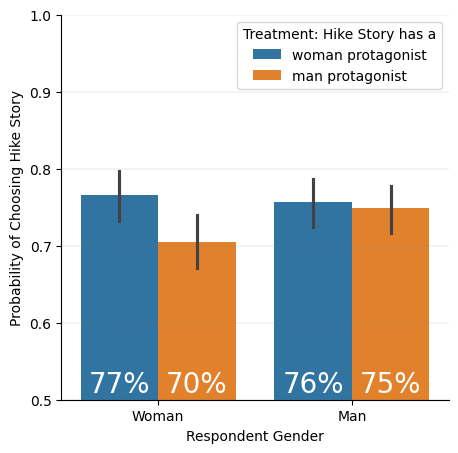

In [ ]:
plt.figure(figsize=(5, 5))
ax = sns.barplot(clean, x="gender", y="chose_hike", order=['Woman', 'Man'], hue='Treatment A', errorbar=('ci', 95))
ax.set_ylim(0.5, 1)
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['woman protagonist',
                                   'man protagonist'], title='Treatment: Hike Story has a')

for p in ax.patches:
  height = p.get_height()
  if height > 0.5:
    ax.text(p.get_x() + p.get_width() / 2., 0.52, f'{int(round(height, 2) * 100)}%', ha='center', va='center', color='white', fontsize=20)


plt.xlabel('Respondent Gender')
plt.ylabel('Probability of Choosing Hike Story')#(r' $\hat{\pi}$ ', rotation=0)
plt.savefig(os.path.join('/content/drive/MyDrive/char_gender/figures/', f'pihats.png'), dpi = 300)
plt.show()

In [ ]:
dicts = []
for gender in ['Woman', 'Man']:

  # print(gender.upper())
  subgroup = clean[clean['gender'] == gender].copy()
  pihat1 = np.mean(subgroup[subgroup['Treatment A'] == 'Hike']['chose_hike'])
  pivar1 = pihat1 * (1 - pihat1)/len(subgroup[subgroup['Treatment A'] == 'Hike'])

  pihat0 = np.mean(subgroup[subgroup['Treatment A'] == 'Other']['chose_hike'])
  pivar0 = pihat0 * (1 - pihat0)/len(subgroup[subgroup['Treatment A'] == 'Other'])

  effect = pihat1-pihat0
  effect_var = pivar1+pivar0
  effect_se = np.sqrt(effect_var)

  cimin = effect - stats.norm.ppf(.975)*effect_se
  cimax = effect + stats.norm.ppf(.975)*effect_se
  d = {'Respondent Gender': gender,
       'effect': effect,
       'cimin': cimin,
       'cimax': cimax}
  dicts.append(d)

  # print(f'pi hat1 {pi_hat1}', f'pi hat0 {pi_hat0}', f'pi hat {pi_hat}')
#print(f'Average treatment effect: {np.average(effects, weights=weights)}')

In [ ]:
df = pd.DataFrame(dicts)
df

,Respondent Gender,effect,cimin,cimax
0,Woman,0.061584,0.016927,0.106240
1,Man,0.007931,-0.035845,0.051707


In [ ]:
df['effect'].values

array([0.06158358, 0.0079309 ])

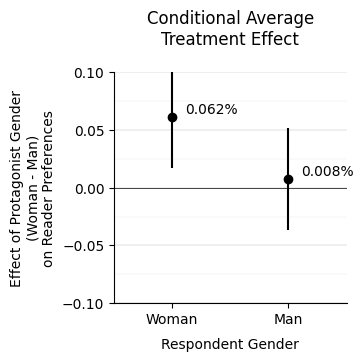

In [ ]:
plt.figure(figsize=(3, 3))
plt.xlim(0,2)
plt.ylim(-0.1, 0.1)
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
for pos in ['top', 'right']:
    plt.gca().spines[pos].set_visible(False)

asymmetric_errors = []
for index, row in df.iterrows():
  asymmetric_errors.append([row['effect'] - row['cimin'], row['cimax'] - row['effect']])
plt.errorbar([0.5,1.5], df['effect'].values, yerr=asymmetric_errors, color='black', fmt='o')

for x, y in zip([0.6, 1.6], df['effect'].values):
  plt.text(x+0.01, y, f'{round(y, 3)}%', ha='left', va='bottom', fontsize=10, color='black')

plt.xticks([0.5, 1.5], labels=['Woman', 'Man'])
plt.yticks(np.arange(-0.1, 0.11, step=0.05))
for y in np.arange(-0.1, 0.11, step=0.025):
    plt.axhline(y=y, color='grey', linestyle='-', linewidth=0.25, alpha=0.2)

plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.xlabel('Respondent Gender', labelpad = 8)
plt.ylabel('Effect of Protagonist Gender\n(Woman - Man)\non Reader Preferences')
plt.title('Conditional Average\nTreatment Effect', pad=20)
plt.savefig(os.path.join('/content/drive/MyDrive/char_gender/figures/', f'cate.png'), dpi = 300, bbox_inches = "tight")
plt.show()

## Bootstrapping

In [ ]:
# Bootstrap calculations
trials = 1000

bootstrapped_ate = []
bootstrapped_pihat = {'Woman': [],
                      'Man': []}

for i in range(trials):

  effects = []
  weights = []

  for gender in ['Woman', 'Man']:

    subgroup = clean[clean['gender'] == gender].copy()

    A1 = subgroup[subgroup['hike_woman'] == 1]
    k = len(A1)
    A1_sample = A1.sample(n=k, replace=True)

    A2 = subgroup[subgroup['hike_woman'] == 0]
    k = len(A2)
    A2_sample = A2.sample(n=k, replace=True)

    pi_hat1 =  np.mean(A1_sample['chose_hike'])
    pi_hat0 =  np.mean(A2_sample['chose_hike'])
    pi_hat = pi_hat1-pi_hat0

    bootstrapped_pihat[gender].append(pi_hat)
    effects.append(pi_hat)
    weights.append(len(subgroup))

  average_effect = np.average(effects, weights=weights)
  bootstrapped_ate.append(average_effect)

In [ ]:
def calculate_CI(bootstrapped):

  sort = sorted(bootstrapped)
  low = round(sort[int(trials*0.025)], 5)
  high = round(sort[int(trials*0.975)], 5)

  return low, high

In [ ]:
for k, v in bootstrapped_pihat.items():
  print(f'{len(v)} Bootstrapped pihat for {k}: {calculate_CI(v)}')

1000 Bootstrapped pihat for Woman: (0.01739, 0.10575)
1000 Bootstrapped pihat for Man: (-0.03374, 0.05557)


In [ ]:
print(f'{len(bootstrapped_ate)} Bootstrapped average treatment effects: {calculate_CI(bootstrapped_ate)}')

1000 Bootstrapped average treatment effects: (0.00328, 0.06401)
